# GMM PROJECT 3 
*Lukas Elenbergas, 1712238*

Variant: **Car, Cat, Guitar**

***Task***: Create a multiclass semantic segmentation model. During presentation of the program, the lecturer may send some test images which you will have to use to demonstrate how well the model works. Alongside that, you will have to explain how the model was implemented.

 - Classes are chosen individually - *minimum 3*.                                                                       **CHECK**
 - The dataset must be devided into *training* and *testing* sets.                                                      **CHECK**
 - The following metrics have to be calculated using the testing set: *Dice*, *Micro-F1* and *Macro-F1* statistics.     **CHECK**
 
The data classes must be picked from [OpenImages V6](https://storage.googleapis.com/openimages/web/index.html) segmentation task dataset.

In [1]:
# ---------------------------------------------------
# IMPORTS
# ---------------------------------------------------
# Fiftyone package install for the Collab environment
"""pip install fiftyone"""
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.labels as foul
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from sklearn.metrics import precision_recall_fscore_support
from IPython.display import display, clear_output
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image
# ---------------------------------------------------
# ENVIRONMENT VARIABLES
# ---------------------------------------------------
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
MODEL_PATH = 'C:\\Projects\\GMM\Models\\'
IMAGE_PATH = 'C:\\Projects\\GMM\\Images\\'
OTHER_PATH = 'C:\\Projects\\GMM\\Other\\3\\'
NUM_ACCUMULATION_STEPS = 2
# ---------------------------------------------------

# DATASET
- Images and their corresponding labels are imported via fiftyone package
- The label data is converted to a proper segmentation mask array
- The segmentation masks are 'class-indexed masks', which are compatible with the used model and loss function
- SemSegDataset() is created to convert the fo dataset to a torch one

In [2]:
# ---------------------------------------------------
# FIFTYONE DATASET
# ---------------------------------------------------
def create_fo_dataset(
        dataset_name: str,
        dataset_type: str,
        dataset_samp: int,
):
    # Fiftyone dataset creation by loading OpenImages V6 dataset from the FO Zoo collection 
    dataset = foz.load_zoo_dataset(
        'open-images-v6',
        dataset_type,
        label_types='segmentations',
        classes=['Car', 'Cat', 'Guitar'],
        label_field='detections',
        only_matching=True,
        max_samples=dataset_samp,
        dataset_name=dataset_name
    )
    # Label conversion into grayscale mask arrays stored within the dataset
    # Makes it more human readable when printed and simplifies further processing
    foul.objects_to_segmentations(
        sample_collection=dataset,
        in_field='detections',
        out_field='segmentations',
        mask_targets={
            1: 'Car', 
            2: 'Cat', 
            3: 'Guitar'
        }
    )
    return dataset
# ---------------------------------------------------

In [3]:
# ---------------------------------------------------
# TORCH DATASET
# ---------------------------------------------------
class SemSegDataset(Dataset):

  def __init__(self, data, label_field='segmentations'):
    self.samples = data
    self.label_field = label_field
    self.img_paths = self.samples.values('filepath')
    self.image_tensor = transforms.ToTensor()
    self.both_transforms = transforms.Compose([
      transforms.CenterCrop((1024, 1024)),
      transforms.Resize((256, 256), interpolation=F.InterpolationMode.NEAREST_EXACT)
    ])

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    sample = self.samples[img_path]
    image = Image.open(img_path).convert('RGB')
    mask = sample[self.label_field].mask
    image_tensor = self.both_transforms(self.image_tensor(image))
    image_tensor = image_tensor.type(torch.float)
    mask_tensor = self.both_transforms((torch.from_numpy(mask)).unsqueeze(0))
    mask_tensor = mask_tensor.type(torch.long)

    return { 'image': image_tensor, 'mask': mask_tensor }

  def __len__(self):
    return len(self.img_paths)

  def sample_path(self, idx):
    return self.img_paths[idx]
# ---------------------------------------------------

# MODEL
The model is an implementation of the **U-Net** architecture which is a fully convolutional neural network (**FCN**). This is a popular and reliable choice when it comes to semantic segmantation tasks.

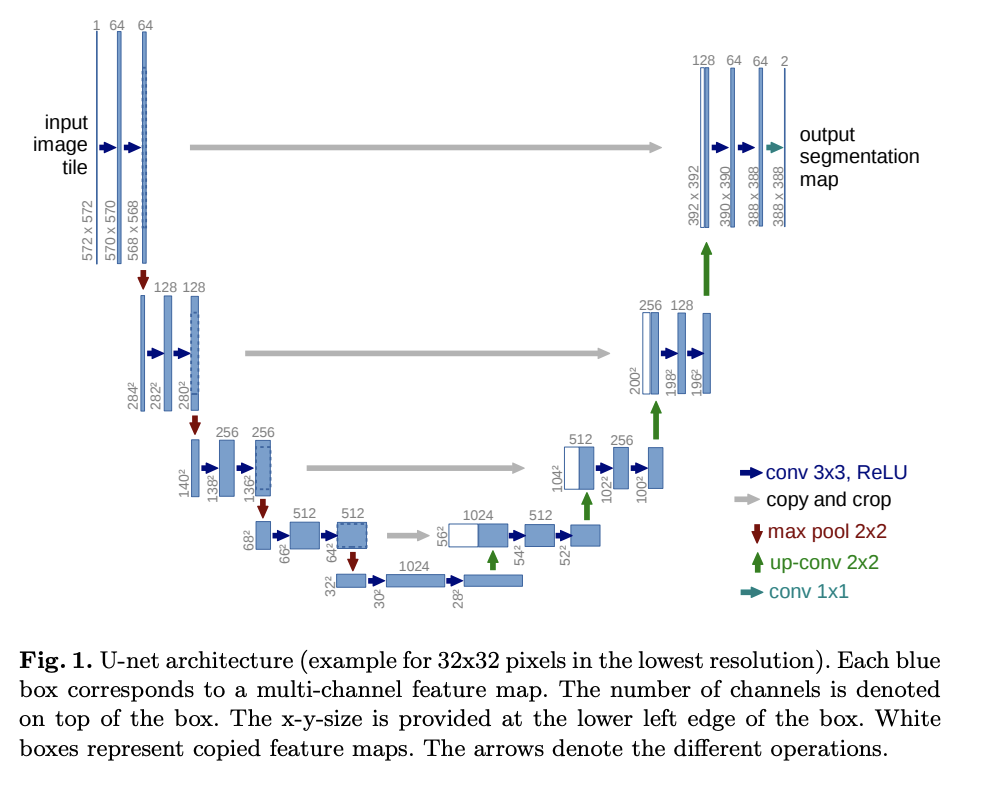

In [4]:
# ---------------------------------------------------
# UNET MODEL
# ---------------------------------------------------
"""
Notable things:
Conv2d - 2D convolution, a.k.a converting one feature matrix into another smaller one
BatchNorm2d - there to help speed up training
ReLU - Rectified Linear Unit activation, which is responsible for neuron activation
MaxPool2d - pooling the largest values from a patch of a feature map to a smaller one
ConvTranspose2d - reverse of 2D confolution, a.k.a converting a feature matrix into a bigger one
center_crop + cat - cropping the center and then concatenating it to a different sequence (for feature retention)
"""
class DoubleConvolution(nn.Module):
  """
  Double 3x3 Convolution Layers

  Both contraction and expansion paths contains steps which have two 3x3 convolutional layers 
  followed by Batch Normalizations and ReLU activations. U-Net paper specifies using 0 padding, 
  but here 1 is used so that the final feature map is uncropped.
  """
  
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.double_conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
    )

  def forward(self, x: torch.Tensor):
    return self.double_conv(x)


class DownSample(nn.Module):
  """
  Each step in the contracting path down-samples the feature map with a 2x2 max pooling layer.
  """
  
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConvolution(in_channels, out_channels)
    )

  def forward(self, x: torch.Tensor):
    return self.maxpool_conv(x)


class UpSample(nn.Module):
  """
  Each step in the expansive path up-samples the feature map with a 2x2 up-convolution.
  Additionally, he corresponding feature map from the contracting path is concatenated 
  with the current feature map.
  """

  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, 
                                 in_channels // 2, 
                                 kernel_size=2, 
                                 stride=2)
    self.conv = DoubleConvolution(in_channels, out_channels)
    
  def forward(self, x1: torch.Tensor, x2: torch.Tensor):
    x1 = self.up(x1)
    x2 = F.center_crop(x2, [x1.shape[2], x1.shape[3]])
    x1 = torch.cat([x2, x1], dim=1)
    return self.conv(x1)


class UNet(nn.Module):
  """
  Using the previously defined classed the model itself can be finally constructed.
  In our case, the input channels will be 3 and output channels 4.
  The input consists of the RGB values of the passed image.
  The ouput is a tensor containing the likelyhood a certain pixel belongs to a particular class.
  """
  
  def __init__(self, in_channels: int, out_channels: int):
    super(UNet, self).__init__()
    self.inc = (DoubleConvolution(in_channels, 64))
    self.down1 = (DownSample(64, 128))
    self.down2 = (DownSample(128, 256))
    self.down3 = (DownSample(256, 512))
    self.down4 = (DownSample(512, 1024))
    self.up1 = (UpSample(1024, 512))
    self.up2 = (UpSample(512, 256))
    self.up3 = (UpSample(256, 128))
    self.up4 = (UpSample(128, 64))
    self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

  def forward(self, x: torch.Tensor):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits
# ---------------------------------------------------

# TRAINING
Preparation for training the model, training itself and plotting loss during it.

- The hyper parameters for training were adjusted via trial and error, keeping hardware limitations in mind.
- The Adam optimizer and CrossEntropyLoss criteria function are used during training.
- The learning rate is adjusted using ReduceLROnPlateau function once the validation loss does not improve for a period of time as a means of overfitting prevention.
- Due to hardware limitations and the nature of the data being trained on, the batch size is 'increaed' artificially via gradient accumulation.
- Gradient clipping is used to prevent exploding gradients, just in case.
- Even though not required, a validation dataset was used to observe the how the model evolves during trainig and if adjustments are required.

In [5]:
# ---------------------------------------------------
# PLOT DRAWING METHOD
# ---------------------------------------------------
def live_plot(loss_ax, loss_fig, loss_arr, avg_loss_arr, val_loss_arr, loss_x):
    x_axis = [i for i in range(len(loss_arr))]                         

    # Drawing the training loss graph
    loss_ax.cla()
    loss_ax.set_ylim(0, 2)
    loss_ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    loss_ax.set_ylabel('Loss')
    loss_ax.set_xlabel('Training Iteration')
    clear_output(wait=True)

    # Plotting loss during epoch
    loss_ax.plot(x_axis, loss_arr, color='Blue', alpha=0.2, label='Loss Over Time')

    # Plotting average epoch loss
    loss_ax.plot(loss_x, avg_loss_arr, color='Blue', label='Average Epoch Loss')
    
    # Plotting validation loss
    loss_ax.plot(loss_x, val_loss_arr, color='Green', label='Validation Loss')

    loss_ax.legend(loc='upper right')
    display(loss_fig)
# ---------------------------------------------------

In [6]:
# ---------------------------------------------------
# MAIN TRAINING METHOD
# ---------------------------------------------------
def train_model(
    model,
    device,
    train_dataset,
    validation_dataset,
    weights,
    epochs: int = 40,  # Ideally 80
    batch_size: int = 4,
    learning_rate: float = 1e-5,
    gradient_clipping: float = 1.0
):
  # 1. Variables for loss graph tracking
  loss_arr = []
  avg_loss_arr = []
  val_loss_arr = []
  loss_x = []
  loss_fig = plt.figure()
  loss_ax = loss_fig.add_subplot(1, 1, 1)

  # 2. Creating training and validation data loaders
  loader_args = dict(batch_size=batch_size, pin_memory=True)
  train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
  val_loader = DataLoader(validation_dataset, shuffle=True, drop_last=True, **loader_args)
  
  # 3. Set up optimizer and loss function
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
  loss_function = nn.CrossEntropyLoss(weight=weights)

  # 4. Begining of training
  for epoch in range(epochs):

    """ TRAINING ROUND """
    model.train()
    # Variables for loss plotting and gradient accumulation
    total_epoch_loss = 0
    total_epoch_loss_count = 0
    accumulation_loss = 0
    for batch_idx, batch in enumerate(train_loader):
      # Generating model output
      images, masks = batch['image'].to(device), batch['mask'].to(device)
      outputs = model(images)
      
      # Loss calculation
      loss = loss_function(outputs, masks.squeeze(1))
      loss = loss / NUM_ACCUMULATION_STEPS
      accumulation_loss += loss
      # Cleanup to reduce memory consumption
      del loss
      del outputs

      # Backpropagation and parameter update
      if (batch_idx + 1) % NUM_ACCUMULATION_STEPS == 0:
        optimizer.zero_grad()
        accumulation_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        # Loss array update and dditional preparation for loss plotting
        loss_arr_item = accumulation_loss.to(torch.device('cpu'))
        loss_arr.append(loss_arr_item.item())
        total_epoch_loss += accumulation_loss
        total_epoch_loss_count += 1
        accumulation_loss = 0
    # More loss plotting prep
    loss_x.append(len(loss_arr))
    current_avg_loss = total_epoch_loss / total_epoch_loss_count
    current_avg_loss = current_avg_loss.to(torch.device('cpu'))
    avg_loss_arr.append(current_avg_loss.item())

    """ VALIDATION ROUND """
    model.eval()
    # Variables for validation loss plotting
    val_loss_count = 0
    val_loss_sum = 0
    for val_batch in val_loader:
      val_images, val_masks = val_batch['image'].to(device), val_batch['mask'].to(device)
      val_outputs = model(val_images)
      with torch.no_grad():
        val_loss = loss_function(val_outputs, val_masks.squeeze(1))
      val_loss_sum += val_loss
      val_loss_count += 1
      # Cleanup to reduce memory consumption
      del val_loss
      del val_outputs

    # Validation loss plotting prep
    current_val_loss = val_loss_sum / val_loss_count
    val_loss_arr_item = current_val_loss.to(torch.device('cpu'))
    val_loss_arr.append(val_loss_arr_item.item())

    # Learning rate adjustment handling
    scheduler.step(val_loss_arr_item)

    # Training and validation loss plotting
    live_plot(loss_ax, loss_fig, loss_arr, avg_loss_arr, val_loss_arr, loss_x)

  return loss_arr, val_loss_arr, loss_x
# ---------------------------------------------------

In [7]:
# ---------------------------------------------------
# PREP BEFORE TRAINING
# ---------------------------------------------------
# DEVICE INIT
# ---------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')
# ---------------------------------------------------
# MODEL INIT
# ---------------------------------------------------
model = UNet(in_channels=3, out_channels=4)
model = model.to(memory_format=torch.channels_last)
model.to(device=device)
# ---------------------------------------------------
# DATASET SPLIT
# ---------------------------------------------------
dataset_size = 8000
split_ratio = 0.2
validation_split = test_split = int(dataset_size * split_ratio)
train_split = dataset_size - (validation_split + test_split)
# ---------------------------------------------------
# DATASET INIT (VIA CREATION OR LOADING)
# ---------------------------------------------------
if 'Training_3' and 'Validation_3' not in fo.list_datasets():
    what_do = 0
else:
    what_do = 1
match what_do:
    case 0:  # CREATING THE TRAINING & VALIDATION DATASETS AFTER DELETING ANY OLDER ONES
        train_dataset = SemSegDataset(create_fo_dataset('Training_3', 'train', train_split))
        validation_dataset = SemSegDataset(create_fo_dataset('Validation_3', 'validation', validation_split))
    case 1:  # LOADING THE TRAINING & VALIDATION DATASETS
        train_dataset = SemSegDataset(fo.load_dataset('Training_3'))
        validation_dataset = SemSegDataset(fo.load_dataset('Validation_3'))
# ---------------------------------------------------
# CLASS WEIGHTS
# ---------------------------------------------------
weights = torch.Tensor([0.1, 0.3, 0.3, 0.3])
weights = weights.to(device=device, dtype=torch.float)
# ---------------------------------------------------

Using device cuda


In [8]:
# ---------------------------------------------------
# TRAINING INIT
# ---------------------------------------------------
train = False

if train:
    final_loss, final_val_loss, loss_x = train_model(
        model=model, 
        device=device,
        train_dataset=train_dataset, 
        validation_dataset=validation_dataset,
        weights=weights
        )
# ---------------------------------------------------

# EVERYTHING ELSE

In [9]:
# ---------------------------------------------------
# MODEL AND LOSS DATA MANAGEMENT
# ---------------------------------------------------
do_what = 1
model_name = '3_model_final'

match do_what:
    case 0:  # SAVE MODEL AND RELATED DATA
        torch.save(model.state_dict(), MODEL_PATH + model_name)
        np.save(model_name + '_final_loss.npy', final_loss)
        np.save(model_name + '_final_val_loss.npy', final_val_loss)
        np.save(model_name + '_loss_x.npy', loss_x)
    case 1:  # LOAD MODEL AND RELATED DDATA
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = UNet(in_channels=3, out_channels=4)
        model = model.to(memory_format=torch.channels_last)
        model.load_state_dict(torch.load(MODEL_PATH + model_name))
        model.to(device=device)
        final_loss = np.load(OTHER_PATH + model_name + '_final_loss.npy')
        final_val_loss = np.load(OTHER_PATH + model_name + '_final_val_loss.npy')
        loss_x = np.load(OTHER_PATH + model_name + '_loss_x.npy')
# ---------------------------------------------------

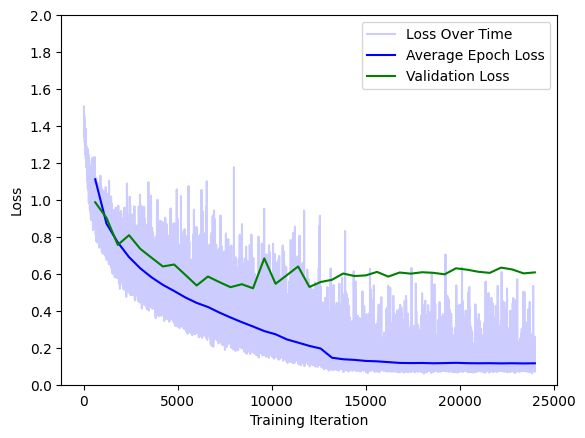

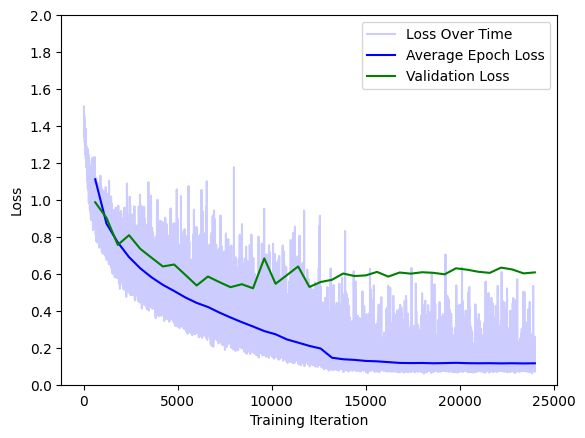

In [10]:
# ---------------------------------------------------
# REDISPLAY LOSS GRAPH
# ---------------------------------------------------
loss_fig = plt.figure()
loss_ax = loss_fig.add_subplot(1, 1, 1)

elements_per_epoch = int(train_split / 8)
avg_loss_arr = []

for i in range(0, len(final_loss), elements_per_epoch):
    chunk = final_loss[i:i+elements_per_epoch]
    average = sum(chunk) / elements_per_epoch
    avg_loss_arr.append(average)

live_plot(loss_ax, loss_fig, final_loss, avg_loss_arr, final_val_loss, loss_x)
# ---------------------------------------------------

In [11]:
# ---------------------------------------------------
# METRIC CALCULATION
# ---------------------------------------------------
# TESTING DATASET INIT
# ---------------------------------------------------
if 'Testing_3' not in fo.list_datasets():
    # CREATING THE TESTING DATASET
    testing_dataset = SemSegDataset(create_fo_dataset('Testing_3', 'test', test_split))
else:
    # LOADING THE TESTING DATASET
    testing_dataset = SemSegDataset(fo.load_dataset('Testing_3'))
# ---------------------------------------------------
# DICE SCORE, MICRO-F1 & MACRO-F1
# ---------------------------------------------------
new_old_run = 0
match new_old_run:
    case 0:  # Just started the run and need to recalculate the metrics
        dice_score_list = []
        micro_f1_list = []
        macro_f1_list = []
    case 1:  # The metrics have already been calculated
        pass

model.eval()
if not dice_score_list:
    for iterator in range(len(testing_dataset)):
        # Getting the true mask, storing and making it binary
        true_mask = testing_dataset[iterator]['mask']
        true_mask = torch.squeeze(true_mask)
        # Getting the predicted maskm, storing it and making it binary
        input_image = testing_dataset[iterator]['image']
        input_image = input_image.to(device)
        predicted_mask = torch.argmax(torch.squeeze(model(input_image.unsqueeze(0))), dim=0)
        predicted_mask = predicted_mask.cpu()
        # Calculating Dice score and adding it to the result list
        dice_score_item = 0
        for class_id in range(1, 4):
            true_mask_per_class = true_mask == class_id
            predicted_mask_per_class = predicted_mask == class_id

            intersection = np.logical_and(true_mask_per_class, predicted_mask_per_class).sum()
            union = true_mask_per_class.sum() + predicted_mask_per_class.sum()

            if intersection == 0 and union == 0:
                dice_score_item += 1.0
            else:
                dice_score_item += (2.0 * intersection + 1e-5) / (union + 1e-5)
        
        dice_score_list.append((dice_score_item / 3).numpy())
        # Calculating Micro-F1 and Macro-F1 and adding them to respective lists
        true_mask = true_mask.flatten()
        predicted_mask = predicted_mask.flatten()
        _, _, micro_f1, _ = precision_recall_fscore_support(true_mask, predicted_mask, labels=[0, 1, 2, 3], average='micro', zero_division=0)
        _, _, macro_f1, _ = precision_recall_fscore_support(true_mask, predicted_mask, labels=[0, 1, 2, 3], average='macro', zero_division=0)
        micro_f1_list.append(micro_f1)
        macro_f1_list.append(macro_f1)


# Getting overall average scores from the respective lists
print('The average Dice score of the model: ', sum(dice_score_list) / len(dice_score_list))
print('Micro-F1 Score: ', sum(micro_f1_list)/len(micro_f1_list))
print('Macro-F1 Score: ', sum(macro_f1_list)/len(macro_f1_list))
# ---------------------------------------------------

The average Dice score of the model:  0.7133361459656961
Micro-F1 Score:  0.8530114459991455
Macro-F1 Score:  0.3682901974107662


In [12]:
# ---------------------------------------------------
# MODEL PRESENTATION
# ---------------------------------------------------
# LOADING IMAGE
# ---------------------------------------------------
image_name = '8.jpg'
test_image_path = IMAGE_PATH + image_name
original_image = test_image = Image.open(test_image_path).convert('RGB')
# ---------------------------------------------------
# REQUIRED TRANSFORMATIONS
# ---------------------------------------------------
back_to_image = transforms.ToPILImage()

image_transform_one = transforms.ToTensor()
test_image = image_transform_one(test_image)
y_dimension = test_image.size(dim=1)
x_dimension = test_image.size(dim=2)

longest_dimemsion = y_dimension if y_dimension > x_dimension else x_dimension
image_transform_two = transforms.Compose([
    transforms.CenterCrop((longest_dimemsion, longest_dimemsion)),
    transforms.Resize((256, 256), interpolation=F.InterpolationMode.NEAREST_EXACT)
])
test_image = image_transform_two(test_image)
# ---------------------------------------------------
# PASSING THE IMAGE THE MODEL
# ---------------------------------------------------
test_image = test_image.to(device)
test_prediction = torch.argmax(torch.squeeze(model(test_image.unsqueeze(0))), dim=0)
# ---------------------------------------------------
# SCALING THE OUTPUT MASK BACK TO ORIGINAL IMAGE SIZE
# ---------------------------------------------------
mask_rescale_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((longest_dimemsion, longest_dimemsion), interpolation=F.InterpolationMode.NEAREST_EXACT),
    transforms.CenterCrop((y_dimension, x_dimension)),
])
test_prediction = mask_rescale_transform(test_prediction.type(torch.float64))
# ---------------------------------------------------
# DISPLAYING THE RESULT BY OVERLAYING THE MASK
# ---------------------------------------------------
"""
The class numbers get changed within the mask array to greyscale numbers, so:
- Class 1 (Car) is 255
- Class 2 (Cat) is 254
- Class 3 (Guitar) is 253
"""
class_colors = {
    255: (1, 56, 106),      # Marine for Car
    254: (255, 182, 193),   # Light pink for Cat
    253: (255, 191, 0),     # Amber for Guitar
}

overlay = Image.new('RGBA', original_image.size)

for y in range(test_prediction.size[1]):
    for x in range(test_prediction.size[0]):
        pixel_value = test_prediction.getpixel((x, y))
        if pixel_value in class_colors:
            color = class_colors[pixel_value]
            overlay.putpixel((x, y), color + (128,))

final_image = Image.alpha_composite(original_image.convert('RGBA'), overlay)
final_image.show()
# ---------------------------------------------------